# Neural Structured Learning for adverserial image classification

The core idea of adversarial learning is to train a model with adversarially-perturbed data (called adversarial examples) in addition to the organic training data. The adversarial examples are constructed to intentionally mislead the model into making wrong predictions or classifications. By training with such examples, the model learns to be robust against adversarial perturbation when making predictions.

In this tutorial, we illustrate the following procedure of applying adversarial learning to obtain robust models using the Neural Structured Learning framework:

Creata a neural network as a base model. In this tutorial, the base model is created with the tf.keras functional API; this procedure is compatible with models created by tf.keras sequential and subclassing APIs as well.


Wrap the base model with the AdversarialRegularization wrapper class, which is provided by the NSL framework, to create a new tf.keras.Model instance. This new model will include the adversarial loss as a regularization term in its training objective.


Convert examples in the training data to feature dictionaries.
Train and evaluate the new model.


In [0]:
%tensorflow_version 2.x

In [0]:
# !pip install neural-structured-learning

In [0]:
import matplotlib.pyplot as plt
import neural_structured_learning as nsl
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

# Hyperparamters

Hyperparameters

We collect and explain the hyperparameters (in an HParams object) for model training and evaluation.

Input/Output:

input_shape: The shape of the input tensor. Each image is 28-by-28 pixels with 1 channel.

num_classes: There are a total of 10 classes, corresponding to 10 digits [0-9].

Model architecture:

conv_filters: A list of numbers, each specifying the number of filters in a convolutional layer.

kernel_size: The size of 2D convolution window, shared by all convolutional layers.

pool_size: Factors to downscale the image in each max-pooling layer.
num_fc_units: The number of units (i.e., width) of each fully-connected layer.

Training and evaluation:

batch_size: Batch size used for training and evaluation.

epochs: The number of training epochs.

Adversarial learning:

adv_multiplier: The weight of adversarial loss in the training objective, relative to the labeled loss.

adv_step_size: The magnitude of adversarial perturbation.

adv_grad_norm: The norm to measure the magnitude of adversarial perturbation.


In [0]:
class HParams(object):
  def __init__(self):
    ## CNN Parameters
    self.input_shape = [28, 28, 1]
    self.num_classes = 10
    self.conv_filters = [32, 64, 64]
    self.kernel_size = (3, 3)
    self.pool_size = (2, 2)
    self.num_fc_units = [64]
    self.batch_size = 32
    self.epochs = 5
    ## Neural structured Learning parameters
    self.adv_multiplier = 0.2
    self.adv_step_size = 0.2
    self.adv_grad_norm = 'infinity'

In [0]:
HPARAMS = HParams()

# Load the MNIST Dataset

In [0]:
dataset = tfds.load('mnist')
train_dataset = dataset['train']
test_dataset = dataset['test']

In [0]:
IMAGE_INPUT_NAME = 'image'
LABEL_INPUT_NAME = 'label'

# Normalize and create train data

In [0]:
def normalize(features):
    features[IMAGE_INPUT_NAME] = tf.cast(features[IMAGE_INPUT_NAME], dtype=tf.float32) / 255.0
    return features

def convert_to_tuples(features):
    return features[IMAGE_INPUT_NAME], features[LABEL_INPUT_NAME]

def convert_to_dict(image, label):
    return {IMAGE_INPUT_NAME : image, LABEL_INPUT_NAME : label}


In [0]:
train_dataset = train_dataset.map(normalize).shuffle(10000).batch(HPARAMS.batch_size).map(convert_to_tuples)
test_dataset = test_dataset.map(normalize).batch(HPARAMS.batch_size).map(convert_to_tuples)

# Build a Base Model

Can be any sequential, functional or subclassed

In [0]:
def build_base_model(hparams):
  """Builds a model according to the architecture defined in `hparams`."""
  inputs = tf.keras.Input(
      shape=hparams.input_shape, dtype=tf.float32, name=IMAGE_INPUT_NAME)

  x = inputs
  for i, num_filters in enumerate(hparams.conv_filters):
    x = tf.keras.layers.Conv2D(
        num_filters, hparams.kernel_size, activation='relu')(
            x)
    if i < len(hparams.conv_filters) - 1:
      # max pooling between convolutional layers
      x = tf.keras.layers.MaxPooling2D(hparams.pool_size)(x)
  x = tf.keras.layers.Flatten()(x)
  for num_units in hparams.num_fc_units:
    x = tf.keras.layers.Dense(num_units, activation='relu')(x)
  pred = tf.keras.layers.Dense(hparams.num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs=inputs, outputs=pred)
  return model


In [0]:
base_model = build_base_model(HPARAMS)
base_model.summary()

In [0]:
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['acc'])
base_model.fit(train_dataset, epochs=HPARAMS.epochs)

In [17]:
results = base_model.evaluate(test_dataset)
named_results = dict(zip(base_model.metrics_names, results))
print('\naccuracy:', named_results['acc'])

313/313 [==============================] - 2s 7ms/step - loss: 0.0370 - acc: 0.9902

accuracy: 0.9901999831199646


# Adding the Adverserial Regularization

Here we show how to incorporate adversarial training into a Keras model with a few lines of code, using the NSL framework. The base model is wrapped to create a new tf.Keras.Model, whose training objective includes adversarial regularization.

First, we create a config object with all relevant hyperparameters using the helper function nsl.configs.make_adv_reg_config.

In [0]:
adv_configs = nsl.configs.make_adv_reg_config(multiplier=HPARAMS.adv_multiplier, adv_step_size=HPARAMS.adv_step_size,
                                              adv_grad_norm=HPARAMS.adv_grad_norm)

Now we can wrap a base model with AdversarialRegularization. Here we create a new base model (base_adv_model), so that the existing one (base_model) can be used in later comparison.

The returned adv_model is a tf.keras.Model object, whose training objective includes a regularization term for the adversarial loss. To compute that loss, the model has to have access to the label information (feature label), in addition to regular input (feature image). For this reason, we convert the examples in the datasets from tuples back to dictionaries. And we tell the model which feature contains the label information via the label_keys parameter.

In [0]:
base_adv_model = build_base_model(HPARAMS)

In [0]:
adv_model = nsl.keras.AdversarialRegularization(base_adv_model, label_keys=[LABEL_INPUT_NAME], adv_config=adv_configs)

In [0]:
train_set_adv = train_dataset.map(convert_to_dict)
test_set_adv = test_dataset.map(convert_to_dict)

Next we compile, train, and evaluate the adversarial-regularized model. There might be warnings like "Output missing from loss dictionary," which is fine because the adv_model doesn't rely on the base implementation to calculate the total loss.

In [0]:
adv_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [0]:
adv_model.fit(train_set_adv, epochs=HPARAMS.epochs)

In [0]:
results = adv_model.evaluate(test_set_adv)
named_results = dict(zip(adv_model.metrics_names, results))
print('\naccuracy:', named_results['sparse_categorical_accuracy'])

# Robustness under Adversarial perturbations

Now we compare the base model and the adversarial-regularized model for robustness under adversarial perturbation.

We will use the AdversarialRegularization.perturb_on_batch function for generating adversarially perturbed examples. And we would like the generation based on the base model. To do so, we wrap the base model with AdversarialRegularization. Note that as long as we don't invoke training (Model.fit), the learned variables in the model won't change and the model is still the same one as in section Base Model.

In [0]:
reference_model = nsl.keras.AdversarialRegularization(base_model, label_keys=[LABEL_INPUT_NAME], adv_config=adv_configs)

In [0]:
reference_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

We collect in a dictionary the models to be evaluted, and also create a metric object for each of the models.

Note that we take adv_model.base_model in order to have the same input format (not requiring label information) as the base model. The learned variables in adv_model.base_model are the same as those in adv_model.

In [0]:
model_to_eval = {
    'base' : base_model,
    'adv-regularized' : adv_model.base_model
}

In [0]:
metrics = {
    name: tf.keras.metrics.SparseCategoricalAccuracy()
    for name in model_to_eval.keys()
}

Here is the loop to generate perturbed examples and to evaluate models with them. We save the perturbed images, labels, and predictions for visualization in the next section.


In [0]:
perturbed_images, labels, predictions = [], [], []

for batch in test_set_adv:
    perturbed_batch = reference_model.perturb_on_batch(batch)
    perturbed_batch[IMAGE_INPUT_NAME] = tf.clip_by_value(perturbed_batch[IMAGE_INPUT_NAME], 0.0, 1.0)

    y_true = perturbed_batch.pop(LABEL_INPUT_NAME)
    perturbed_images.append(perturbed_batch[IMAGE_INPUT_NAME].numpy())
    labels.append(y_true.numpy())
    predictions.append({})

    for name, model in model_to_eval.items():
        y_pred = model(perturbed_batch)
        metrics[name](y_true, y_pred)
        predictions[-1][name] = tf.argmax(y_pred, axis=-1).numpy()

    for name, metric in metrics.items():
        print('%s model accuracy: %f' % (name, metric.result().numpy()))




We can see that the accuracy of the base model drops dramatically (from 99% to about 50%) when the input is perturbed adversarially. On the other hand, the accuracy of the adversarial-regularized model only degrades a little (from 99% to 95%). This demonstrates the effectiveness of adversarial learning on improving model's robustness.

# Examples of adversarially-perturbed images

Here we take a look at the adversarially-perturbed images. We can see that the perturbed images still show digits recognizable by human, but can successfully fool the base model.

accuracy in batch 0:
base model: 22 / 32
adv-regularized model: 31 / 32


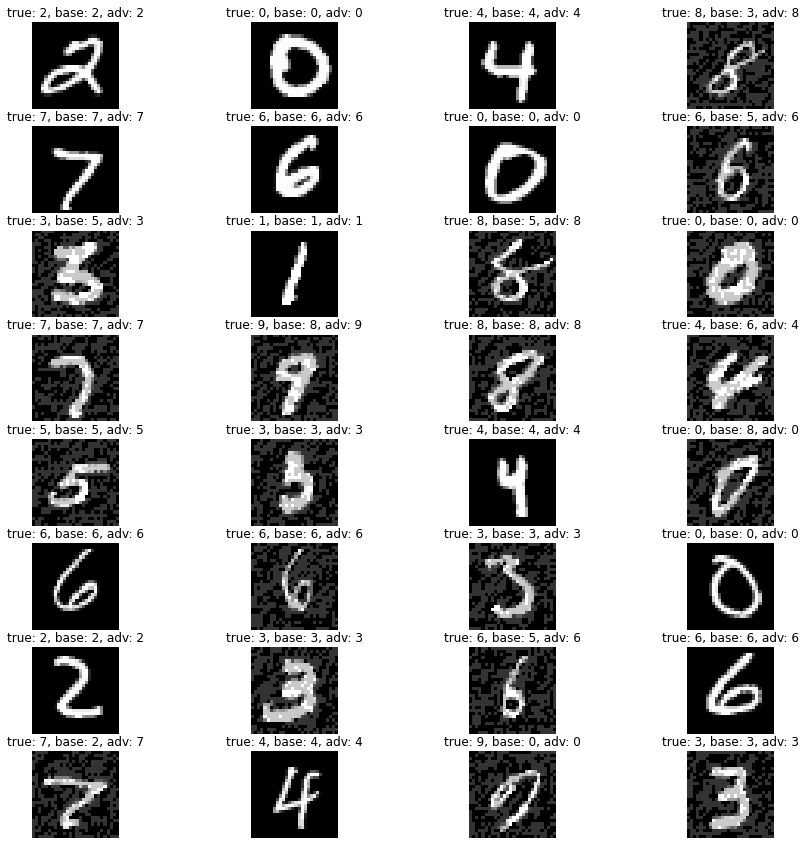

In [35]:
batch_index = 0

batch_image = perturbed_images[batch_index]
batch_label = labels[batch_index]
batch_pred = predictions[batch_index]

batch_size = HPARAMS.batch_size
n_col = 4
n_row = (batch_size + n_col - 1) / n_col

print('accuracy in batch %d:' % batch_index)
for name, pred in batch_pred.items():
  print('%s model: %d / %d' % (name, np.sum(batch_label == pred), batch_size))

plt.figure(figsize=(15, 15))
for i, (image, y) in enumerate(zip(batch_image, batch_label)):
  y_base = batch_pred['base'][i]
  y_adv = batch_pred['adv-regularized'][i]
  plt.subplot(n_row, n_col, i+1)
  plt.title('true: %d, base: %d, adv: %d' % (y, y_base, y_adv))
  plt.imshow(tf.keras.preprocessing.image.array_to_img(image), cmap='gray')
  plt.axis('off')

plt.show()
